In [66]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import gym
from gym import spaces
from gym.utils import seeding
%matplotlib inline

# GridWorld class

In [32]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
                grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
                return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [33]:
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

In [34]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10):
        self.player_name = player_name
        self.card = []
        self.starter_balance = start_balance
        self.total_balance = start_balance

    def recharge_account(self):
        self.total_balance = self.starter_balance
        
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance)) 

In [35]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

# Blackjack Environment

In [36]:
class BlackjackEnv(gym.Env):
    """
    Simple blackjack environment
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation is: the players current sum, players current card, players balance left, 
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    Parameters
    ==========
    natural      boolean
                 option for 50% more reward on natural blackjack 
    
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.total_players = 1
        self.players = {}
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        self.max_bet_cap = 10

    def add_player(self, player_class):
        if player_class not in self.players and len(self.players) < self.total_players:
            self.players[player_class.player_name] = player_class
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.players)))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, player_name, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.players[player_name].card.append(draw_card(self.np_random))
            if is_bust(self.players[player_name].card):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.players[player_name].card), score(self.dealer))
            if self.natural and is_natural(self.players[player_name].card) and reward == 1:
                reward = 1.5
        if done:
            self.settle_balance(int(reward), player_name)
        return {'state':self._get_obs(player_name), 'reward': reward, 'is_round_done': done}

    def _get_obs(self, player_name):
        return {'player_info':self.get_player_obs(player_name), 
                'dealer_info': self.dealer[0]}

    def get_player_obs(self, player_name):
        return {'player_sum_card':sum_hand(self.players[player_name].card), 
                'player_card':self.players[player_name].card, 
                'player_total_balance':self.players[player_name].total_balance, 
                'usable_ace' : usable_ace(self.players[player_name].card)}
    
    def get_valid_bet_amount(self, player_name):
        print("player name: {} money left: {}".format(player_name, self.players[player_name].total_balance))
        if self.players[player_name].total_balance < 1:
            return {'is_round_done': True, 'valid_bet_amount': -1}
        max_bet_upper_limit = self.players[player_name].total_balance
        if self.players[player_name].total_balance >= self.max_bet_cap:
            max_bet_upper_limit = self.max_bet_cap            
        return {'is_round_done': False, 'valid_bet_amount': list(range(1, max_bet_upper_limit+1))}
            
    def init_round(self, player_name):         
        self.dealer = draw_hand(self.np_random)
        self.players[player_name].card = draw_hand(self.np_random)
        return {'state': self._get_obs(player_name)}        

    def bet_money(self, player_name, bet_amount):
        self.players[player_name].total_balance -= bet_amount
        self.round_bet_info[player_name] = bet_amount
            
    def settle_balance(self, is_winner, player_name):
        if is_winner == 1:
            print("player winner")
            self.players[player_name].total_balance += (2 * self.round_bet_info[player_name])
        elif is_winner == 0:
            print("Draw match")
            self.players[player_name].total_balance += self.round_bet_info[player_name]
        else:
            print("player loser, wont get back the money, try next round")
    
    def reset(self, natural=False):
        for player_name, player_class in self.players.items():
            player_class.recharge_account()
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        

# Example run with random players

In [37]:
env = BlackjackEnv()
player1 = Player('player1')
env.add_player(player1)
#Number of games
number_of_games = 10

#Number of rounds
number_of_rounds = 20

for _game in range(number_of_games):

    env.reset()
    print("-"* 50)
    print("Game Number: {}".format(_game + 1))
    print("-"* 50)
    for _round in range(number_of_rounds): 
        print("%"* 50)
        print("Game Number: {} Round Number: {}".format(_game+1, _round+1))
        print("%"* 50)
        
        #Check if you have enough money left in the account to bet, if not break and start a new game
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
            print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']
        
        #Get the observations i.e state and use it to decide how much you want to bet
        round_obs = env.init_round(player1.player_name)
        print("Initial state: {}".format(round_obs))  
        
        # If you have just $1 left in the bank, you have no choice but to bet that amount 
        # and hopefully leave it to the fate for your agent to win and continue playing or just
        # start a new game
        if len(bet_amount) == 1 and bet_amount[0] == 1:
            print("You can only bet 1. So betting only 1.")
            random_bet = 1
        else:
            random_bet = np.random.choice(bet_amount)
        print("Random Init Bet: {}".format(random_bet))
        env.bet_money(player1.player_name, random_bet)
          
        
        # Look at the state and take actions, here the actions are selected randomly
        # you can use the agent to select the action
        random_action = np.random.randint(0, 2)
        print("Action taken: {}".format(random_action))

        #Use the selected action to actually take the action in env by calling step
        round_obs = env.step(player1.player_name, random_action)
        print("State after 1st action: {}".format(round_obs))

        #Check if the game is not over, if your action is stand then the game is over, else
        #the game continues in this loop until your action is stand
        while not round_obs['is_round_done']:
            #Select an random action and take the action
            random_action = np.random.randint(0, 2)
            print("Action taken: {}".format(random_action))
            round_obs = env.step(player1.player_name, random_action)
            print("State after nth action: {}".format(round_obs))

        #Round over, but the game will continue untill you have exhausted your initial money 
        print("Balance Left: {}".format(round_obs['state']['player_info']['player_total_balance']))
        print("Round over")
        print("-%-"*30)
        if (_round + 1) == (number_of_rounds):
            print("Max number of rounds played. If you see the message, you are the winner.")

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [10, 1], 'player_total_balance': 10, 'usable_ace': True}, 'dealer_info': 4}}
Random Init Bet: 8
Action taken: 0
player winner
State after 1st action: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [10, 1], 'player_total_balance': 18, 'usable_ace': True}, 'dealer_info': 4}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 18
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 18
Initial state: {

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

## Review of SARSA and Q-Learning

Both SARSA and Q-learning are Temporal Difference learning approaches. The difference between these approches lies in updating the Q table. 

In SARSA we update the Q with assumption that we follow a certain behavior policy. Thus, we call this as on-policy control, or SARSA.
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

In Q-learning without making assumption of behavior policy, we can explore other possible policies to update the Q. We call this as off-policy control, or Q-learning.
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

If we observe above two formulas used for updating the Q table we can see that in SARSA it is using the actual action that corresponds to s(t+1) to update action at s(t) where as in Q learning it using maximum reward action value at s(t+1) to update action at s(t).

The major difference is that Q-learning uses the action with maximum reward to update the action value. In SARSA, we use an action that is taken in previous state.

## Choice of TD learning and Reason

For both the problems I choose Q learning approach over SARSA because I donot care agents performance during the process of learning. I want the agent to explore all the possible policies and learn optimal greedy policy. In case of Maze problem there is nothing expensive if agent performs bad actions in the name of exploration. I want agent to explore and learn the optimal policy of reaching the goal in minimum number of steps. Same in the case of Blackjack game I want agent to learn by exploring and also in case of Blackjack there can never be bad action until unless we explore it.
SARSA will approach convergence allowing for possible penalities from exploratory moves, while Q learning ignores them. SARSA is very conservative and if there is any large negative closer to optimal path it tends to avoid it where as Q learning tend to trigger that large negative reward in the name of exploration.

I want my agents to learn optimal policies directly as there is no risk or damage occured to agents or environment performing actions while exploring.



# RLAgent for Maze Problem

In [38]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
    
    def greedy(self, Q, s):
        return np.argmax(self.Q[s[0]][s[1]])  # greedy action selection
    
    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(self.Q,s)

    def train(self, start, **params):
        i=1
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        self.epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        
        for j in range(maxiter):

            env.init(start)
            s = env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(self.epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = env.next(a)
                s1 = env.get_cur_state()
                a1 = self.epsilon_greed(self.epsilon, s1)
                
                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))

                # TODO: FINISH SARSA/Q-learning Rule here
                # update self.Q table 
                self.Q[s[0]][s[1]][a] = self.Q[s[0]][s[1]][a] + alpha*(r + gamma*max(self.Q[s1[0]][s1[1]]) - self.Q[s[0]][s[1]][a])
                if env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        env.init(start)
        s = env.get_cur_state()
        #self.epsilon = 0.1
        a = self.epsilon_greed(self.epsilon, s)
        trace = np.array(coord_convert(s, self.size))
        steps=[]
            # run simulation for max number of steps 
        for step in range(maxstep):
            r = env.next(a)
            s1 = env.get_cur_state()
            a1 = self.epsilon_greed(self.epsilon, s1)
            
            trace = np.vstack((trace, coord_convert(s1, self.size)))
            curr = self.env.check_state(s1)
            
            
            if self.env.is_goal():
                break
            
            s = s1
            a = a1
        steps.append(step+1)
        return trace,steps            

# RLAgent for Blackjack

In [68]:
import random
class BlackAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    def __init__(self):
       
        # self.Q table
        
    
    def greedy(self, Q, s,env):
        action= #something
        c=True
        a=Q[s[0]][s[1]]
        print("Available actions: ", action)
        while c:
            if np.argmax(a) in actions:
                action= np.argmax(a)
                c=False
                
            else:
                a=np.delete(a,np.argmax(a))
                c=True
        
        print("selected action",action)
        return action  # greedy action selection
        
        
        
        
   

IndentationError: expected an indented block (<ipython-input-68-28d25a12fc01>, line 13)

In [40]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")
    
    

    ax1 = fig.add_subplot(222)
    # TODO: plot steps
    plt.plot(steps)
    plt.ylabel("No of steps")
    
    

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

In [41]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [42]:
alpha=[]
steps1=[]
for i in range(11):
    agent = RLAgent(env)
    start = [0,0]
    rtrace, steps, trace = agent.train(start, 
                                       gamma=0.99, 
                                       alpha=0.1*i, 
                                       epsilon=0.1, 
                                       maxiter=100, 
                                       maxstep=1000)
    test_start = [0,2]
    test_trace,steps = agent.test(test_start)
    alpha.append(round((0.1*i),1))
    steps1.append(steps)
    print("Alpha: ",round((0.1*i),1),"\tNo. of Steps: ",str(steps))

Alpha:  0.0 	No. of Steps:  [1000]
Alpha:  0.1 	No. of Steps:  [11]
Alpha:  0.2 	No. of Steps:  [9]
Alpha:  0.3 	No. of Steps:  [11]
Alpha:  0.4 	No. of Steps:  [9]
Alpha:  0.5 	No. of Steps:  [23]
Alpha:  0.6 	No. of Steps:  [11]
Alpha:  0.7 	No. of Steps:  [11]
Alpha:  0.8 	No. of Steps:  [31]
Alpha:  0.9 	No. of Steps:  [13]
Alpha:  1.0 	No. of Steps:  [9]


Text(0, 0.5, 'No. of steps')

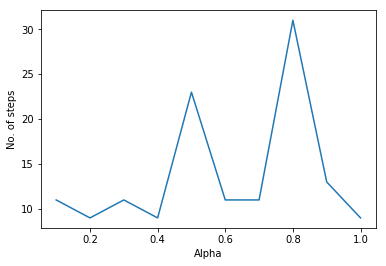

In [43]:
plt.plot(alpha[1:],steps1[1:])
plt.xlabel("Alpha")
plt.ylabel("No. of steps")

In [44]:
epsilon=[]
steps1=[]
for i in range(11):
    agent = RLAgent(env)
    start = [0,0]
    rtrace, steps, trace = agent.train(start, 
                                       gamma=0.99, 
                                       alpha=0.1, 
                                       epsilon=0.1*i, 
                                       maxiter=100, 
                                       maxstep=1000)
    test_start = [0,2]
    test_trace,steps = agent.test(test_start)
    epsilon.append(round((0.1*i),1))
    steps1.append(steps)
    print("Epsilon: ",round((0.1*i),1),"\tNo. of Steps: ",str(steps))

Epsilon:  0.0 	No. of Steps:  [9]
Epsilon:  0.1 	No. of Steps:  [9]
Epsilon:  0.2 	No. of Steps:  [12]
Epsilon:  0.3 	No. of Steps:  [18]
Epsilon:  0.4 	No. of Steps:  [12]
Epsilon:  0.5 	No. of Steps:  [33]
Epsilon:  0.6 	No. of Steps:  [29]
Epsilon:  0.7 	No. of Steps:  [37]
Epsilon:  0.8 	No. of Steps:  [39]
Epsilon:  0.9 	No. of Steps:  [83]
Epsilon:  1.0 	No. of Steps:  [54]


Text(0, 0.5, 'No. of steps')

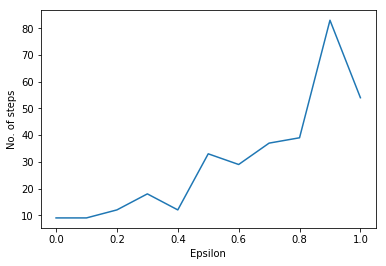

In [45]:
plt.plot(epsilon[0:],steps1[0:])
plt.xlabel("Epsilon")
plt.ylabel("No. of steps")

In [46]:

Gamma=[]
steps1=[]
for i in range(11):
    agent = RLAgent(env)
    start = [0,0]
    rtrace, steps, trace = agent.train(start, 
                                       gamma=0.9+(0.01*i), 
                                       alpha=0.1, 
                                       epsilon=0.1, 
                                       maxiter=100, 
                                       maxstep=1000)
    test_start = [0,2]
    test_trace,steps = agent.test(test_start)
    Gamma.append(round((0.9+(0.01*i)),2))
    steps1.append(steps)
    print("Gamma: ",round((0.9+(0.01*i)),2),"\tNo. of Steps: ",str(steps))

Gamma:  0.9 	No. of Steps:  [10]
Gamma:  0.91 	No. of Steps:  [11]
Gamma:  0.92 	No. of Steps:  [9]
Gamma:  0.93 	No. of Steps:  [12]
Gamma:  0.94 	No. of Steps:  [9]
Gamma:  0.95 	No. of Steps:  [11]
Gamma:  0.96 	No. of Steps:  [11]
Gamma:  0.97 	No. of Steps:  [13]
Gamma:  0.98 	No. of Steps:  [10]
Gamma:  0.99 	No. of Steps:  [11]
Gamma:  1.0 	No. of Steps:  [9]


Text(0, 0.5, 'No. of steps')

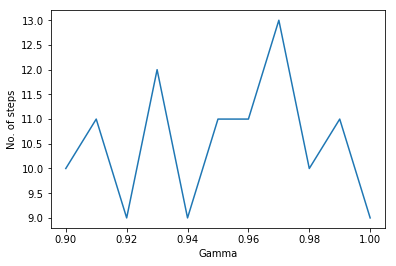

In [47]:
plt.plot(Gamma[0:],steps1[0:])
plt.xlabel("Gamma")
plt.ylabel("No. of steps")

## Report of Selected Parameters for Maze

From the above results and plots we can see that with alpha value of 0.2, epsilon value of 0.2, gamma value of 0.91 agent is taking minimum number of steps. I will be using these three optimal parameters together for final training.

gamma=0.91 

alpha=0.2 

epsilon=0.2

### Training and Testing with GridWorld

In [48]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

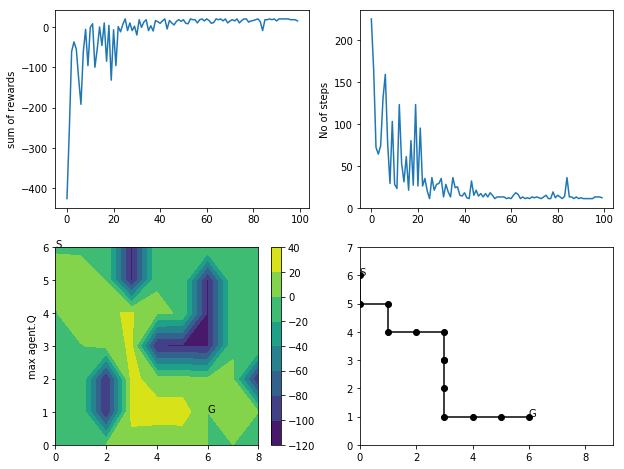

In [49]:
plot_train(agent, rtrace, steps, trace, start)

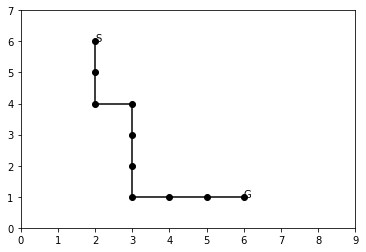

In [50]:
test_start = [0,2]
test_trace,steps = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

[172]

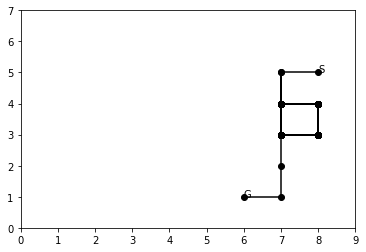

In [51]:
test_start = [1,8]
test_trace,steps = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
steps

# Considering the best parameters for final training 

In [52]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.91, 
                                   alpha=0.2, 
                                   epsilon=0.2, 
                                   maxiter=100, 
                                   maxstep=1000)

# Plots for maze

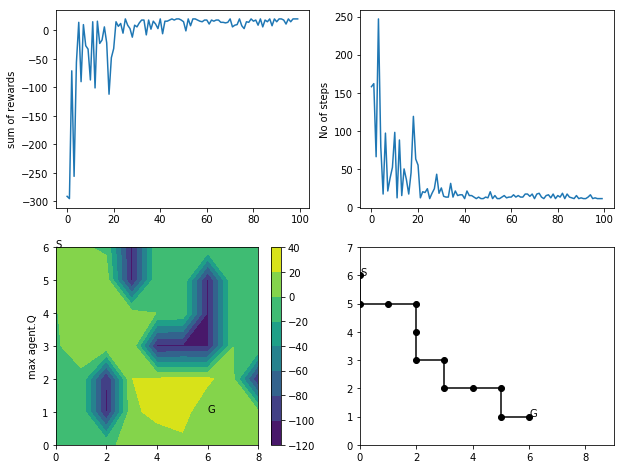

In [53]:
plot_train(agent, rtrace, steps, trace, start)

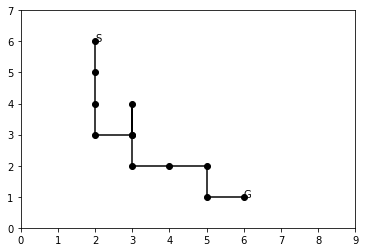

In [54]:
test_start = [0,2]
test_trace,steps = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

[8]

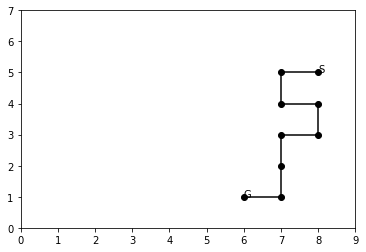

In [55]:
test_start = [1,8]
test_trace,steps = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
steps

[11]

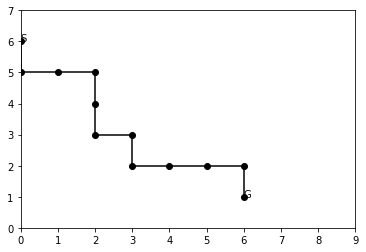

In [56]:
test_start = [0,0]
test_trace,steps = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
steps


[7]

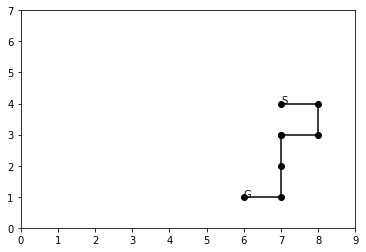

In [57]:
test_start = [2,7]
test_trace,steps = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
steps

In [71]:
# Training and testing the BlackAgent  (RL Agent)
alpha=[]
accuracy=[]
for i in range(11):
    agent=BlackAgent()
    